In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook


def read_arduino(ser,inputBufferSize):
#    data = ser.readline(inputBufferSize)
    data = ser.read(inputBufferSize)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return result

######### define FFT function first ###########

def process_gaussian_fft(t,data_t,sigma_gauss):
    nfft = len(data_t) # number of points
    dt = t[1]-t[0]  # time interval
    maxf = 1/dt     # maximum frequency
    df = 1/np.max(t)   # frequency interval
    f_fft = np.arange(-maxf/2,maxf/2+df,df)          # define frequency domain

    ## DO FFT
    data_f = np.fft.fftshift(np.fft.fft(data_t)) # FFT of data

    ## GAUSSIAN FILTER
#    sigma_gauss = 25  # width of gaussian - defined in the function
    gauss_filter = np.exp(-(f_fft)**2/sigma_gauss**2)   # gaussian filter used
    data_f_filtered= data_f*gauss_filter    # gaussian filter spectrum in frquency domain
    data_t_filtered = np.fft.ifft(np.fft.ifftshift(data_f_filtered))    # bring filtered signal in time domain
    return data_t_filtered

<IPython.core.display.Javascript object>


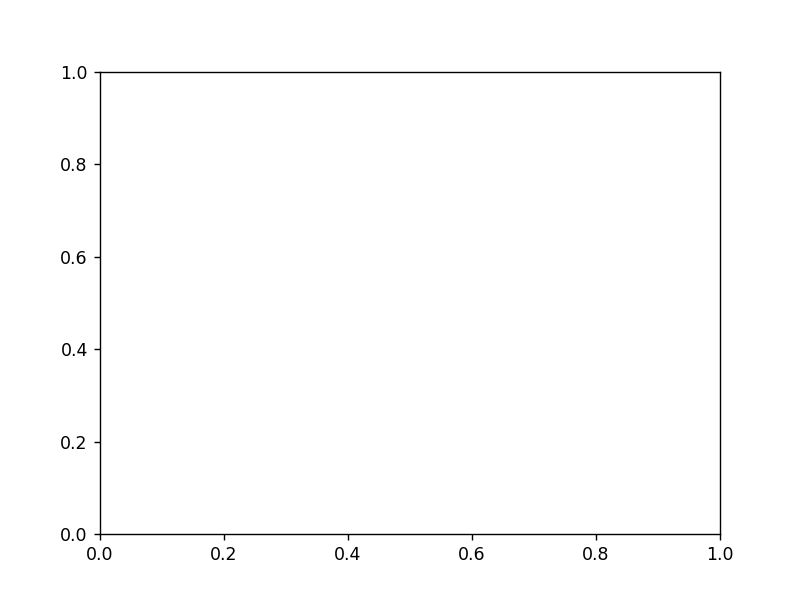

In [2]:
# Read data
baudrate = 230400
cport = 'COM9'  # set the correct port before you run it
#cport = '/dev/tty.usbmodem141101'  # set the correct port before run it
ser = serial.Serial(port=cport, baudrate=baudrate)    # this initializes the animated plot
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


<IPython.core.display.Javascript object>


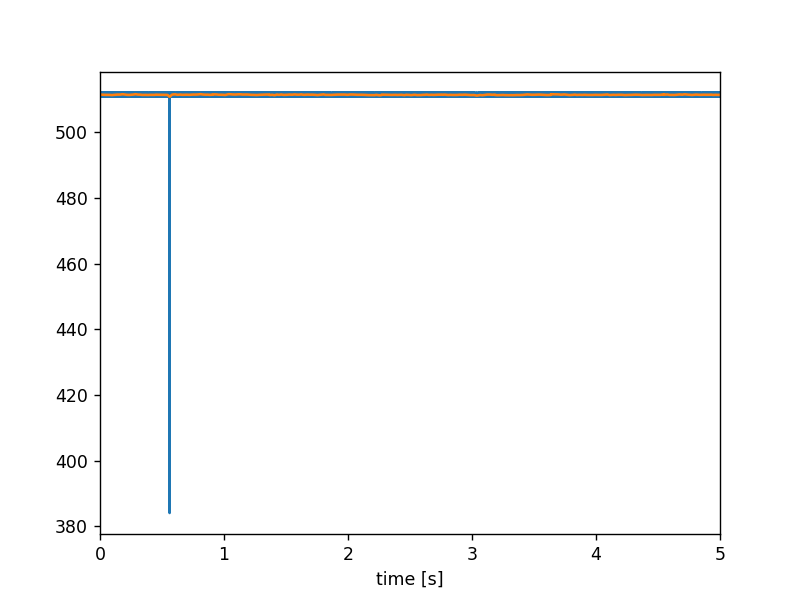

C:\Users\tuniz\Anaconda2\envs\py36\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [3]:
# take continuous data stream 
inputBufferSize = 10000 # keep betweein 2000-20000
ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
ser.set_buffer_size(rx_size = inputBufferSize)

%matplotlib notebook

total_time = 20.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 5; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

T_acquire = inputBufferSize/20000.0    # length of time that data is acquired for 
N_max_loops = max_time/T_acquire    # total number of loops to cover desire time window

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.ion()
fig.show()
fig.canvas.draw()

for k in range(0,int(N_loops)):
    data = read_arduino(ser,inputBufferSize)
    data_temp = process_data(data)
    
    # DO THE GAUSSIAN FILTERING FIRST - OTHERWISE YOUR CODE SLOWS DOWN
    # define temporary time array OF THE WINDOW
    T = inputBufferSize/20000.0*np.linspace(0,1,(data_temp).size)
    sigma_gauss = 25
    data_temp_filtered = process_gaussian_fft(T,data_temp,sigma_gauss)

    if k <= N_max_loops:
        if k==0:
            data_plot = data_temp
            data_plot_filtered = data_temp_filtered
        else:
            data_plot = np.append(data_temp,data_plot)
            data_plot_filtered = np.append(data_temp_filtered,data_plot_filtered)

        t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
        
        data_plot_filtered = np.roll(data_plot_filtered,len(data_temp_filtered))
        data_plot_filtered[0:len(data_temp_filtered)] = data_temp_filtered
        
    t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    t_filtered = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot_filtered).size)

    # same thing here

    plt.xlim([0,max_time])
    ax1.clear()
    ax1.set_xlim(0, max_time)
    plt.xlabel('time [s]')
    ax1.plot(t,data_plot)
    ax1.plot(t_filtered,data_plot_filtered)
    fig.canvas.draw()    
    plt.show()

In [4]:
# close serial port if necessary
if ser.read():
    ser.flushInput()
    ser.flushOutput()
    ser.close()